In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
ecommerce_retail = pd.read_excel("ecommerce retail.xlsx")

In [2]:
#use .info() and .describe() to explore the dataset
ecommerce_retail.info()
ecommerce_retail.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


In [3]:
#Check the number of rows and columns
rows = ecommerce_retail.shape[0] 
cols = ecommerce_retail.shape[1] 
print('Row:',rows)
print('Column:',cols)

Row: 541909
Column: 8


In [4]:
#Filter missing values
ecommerce_retail = ecommerce_retail.dropna()

In [5]:
#Change data type of columns
ecommerce_retail['InvoiceDate'] = pd.to_datetime(ecommerce_retail['InvoiceDate'], format='%Y-%m-%d %H:%M:%S')
ecommerce_retail['CustomerID'] = ecommerce_retail['CustomerID'].astype(np.int64)

In [6]:
#Filter negative values of Quantity and UnitPrice
ecommerce_retail = ecommerce_retail.query('Quantity > 0 and UnitPrice > 0')

In [7]:
#Create 3 tables representing R, F and M respectively

In [8]:
#Recency = subtracting the latest transaction date from each customer's latest transaction date
er_recency = ecommerce_retail.groupby('CustomerID', as_index=False)['InvoiceDate'].max()
er_recency.columns = ['CustomerID','LatestTransactionDate']
recent = dt.datetime.strptime('2011-12-31', '%Y-%m-%d')
er_recency['Recency'] = (recent - er_recency['LatestTransactionDate']).dt.days
er_recency = er_recency.drop('LatestTransactionDate', axis=1)
er_recency

,CustomerID,Recency
0,12346,346
1,12347,23
2,12348,96
3,12349,39
4,12350,331
...,...,...
4333,18280,298
4334,18281,201
4335,18282,28
4336,18283,24


In [9]:
#Frequency = counting the number of transactions for each customer
er_frequency = ecommerce_retail.groupby('CustomerID',as_index=False).agg({'InvoiceNo':'nunique'})
er_frequency.columns = ['CustomerID','Frequency']
er_frequency

,CustomerID,Frequency
0,12346,1
1,12347,7
2,12348,4
3,12349,1
4,12350,1
...,...,...
4333,18280,1
4334,18281,1
4335,18282,2
4336,18283,16


In [10]:
#Monetary =  summing the purchase amounts for each customer
ecommerce_retail['PurchasedAmount'] = ecommerce_retail['Quantity'] * ecommerce_retail['UnitPrice']
er_monetary = ecommerce_retail.groupby('CustomerID',as_index=False).agg({'PurchasedAmount':'sum'})
er_monetary.columns = ['CustomerID','Monetary']
er_monetary

,CustomerID,Monetary
0,12346,77183.60
1,12347,4310.00
2,12348,1797.24
3,12349,1757.55
4,12350,334.40
...,...,...
4333,18280,180.60
4334,18281,80.82
4335,18282,178.05
4336,18283,2094.88


In [11]:
#Now, merge R, F and M tables together
RF = er_recency.merge(er_frequency, on='CustomerID')
er_RFM = RF.merge(er_monetary, on='CustomerID')
er_RFM

,CustomerID,Recency,Frequency,Monetary
0,12346,346,1,77183.60
1,12347,23,7,4310.00
2,12348,96,4,1797.24
3,12349,39,1,1757.55
4,12350,331,1,334.40
...,...,...,...,...
4333,18280,298,1,180.60
4334,18281,201,1,80.82
4335,18282,28,2,178.05
4336,18283,24,16,2094.88


In [12]:
#Score each of R, F and M by using quintile (or from 1 to 5)
R_variable = range(5, 0, -1)
F_variable = range(1, 6)
M_variable = range(1, 6)

er_RFM['R_score'] = pd.qcut(er_RFM['Recency'], q = 5, labels = R_variable)
er_RFM['F_score'] = pd.qcut(er_RFM['Frequency'].rank(method='first'), q = 5, labels = False) + 1
er_RFM['M_score'] = pd.qcut(er_RFM['Monetary'], q = 5, labels = M_variable)

er_RFM

,CustomerID,Recency,Frequency,Monetary,R_score,F_score,M_score
0,12346,346,1,77183.60,1,1,5
1,12347,23,7,4310.00,5,5,5
2,12348,96,4,1797.24,2,4,4
3,12349,39,1,1757.55,4,1,4
4,12350,331,1,334.40,1,1,2
...,...,...,...,...,...,...,...
4333,18280,298,1,180.60,1,2,1
4334,18281,201,1,80.82,1,2,1
4335,18282,28,2,178.05,5,3,1
4336,18283,24,16,2094.88,5,5,5


In [13]:
#Combine R, F, and M elements into RFM scores
er_RFM['RFM_Score'] = er_RFM['R_score'].astype(str) + er_RFM['F_score'].astype(str) + er_RFM['M_score'].astype(str)
er_RFM['RFM_Score'] = er_RFM['RFM_Score'].astype(int)

er_RFM

,CustomerID,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_Score
0,12346,346,1,77183.60,1,1,5,115
1,12347,23,7,4310.00,5,5,5,555
2,12348,96,4,1797.24,2,4,4,244
3,12349,39,1,1757.55,4,1,4,414
4,12350,331,1,334.40,1,1,2,112
...,...,...,...,...,...,...,...,...
4333,18280,298,1,180.60,1,2,1,121
4334,18281,201,1,80.82,1,2,1,121
4335,18282,28,2,178.05,5,3,1,531
4336,18283,24,16,2094.88,5,5,5,555


In [14]:
#import Segmentation table
segmentation = pd.read_excel('ecommerce retail.xlsx', sheet_name='Segmentation')
segmentation.columns = [col.replace(' ', '_') for col in segmentation.columns]
segmentation

,Segment,RFM_Score
0,Champions,"555, 554, 544, 545, 454, 455, 445"
1,Loyal,"543, 444, 435, 355, 354, 345, 344, 335"
2,Potential Loyalist,"553, 551, 552, 541, 542, 533, 532, 531, 452, 4..."
3,New Customers,"512, 511, 422, 421, 412, 411, 311"
4,Promising,"525, 524, 523, 522, 521, 515, 514, 513, 425,42..."
5,Need Attention,"535, 534, 443, 434, 343, 334, 325, 324"
6,About To Sleep,"331, 321, 312, 221, 213, 231, 241, 251"
7,At Risk,"255, 254, 245, 244, 253, 252, 243, 242, 235, 2..."
8,Cannot Lose Them,"155, 154, 144, 214,215,115, 114, 113"
9,Hibernating customers,"332, 322, 233, 232, 223, 222, 132, 123, 122, 2..."


In [15]:
#split the elements in rfm score into each row (an element/row)
segmentation['RFM_Score'] = segmentation['RFM_Score'].str.split(',')
segmentation = segmentation.explode('RFM_Score').reset_index(drop=True)
segmentation['RFM_Score'] = segmentation['RFM_Score'].astype(int)
segmentation.sort_values('RFM_Score')
segmentation

,Segment,RFM_Score
0,Champions,555
1,Champions,554
2,Champions,544
3,Champions,545
4,Champions,454
...,...,...
120,Lost customers,112
121,Lost customers,121
122,Lost customers,131
123,Lost customers,141


In [16]:
#merge er_RFM and segmentation to classify customers based on rfm score
rfm_segment = er_RFM.merge(segmentation, on='RFM_Score', how='left')
rfm_segment

,CustomerID,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_Score,Segment
0,12346,346,1,77183.60,1,1,5,115,Cannot Lose Them
1,12347,23,7,4310.00,5,5,5,555,Champions
2,12348,96,4,1797.24,2,4,4,244,At Risk
3,12349,39,1,1757.55,4,1,4,414,Promising
4,12350,331,1,334.40,1,1,2,112,Lost customers
...,...,...,...,...,...,...,...,...,...
4333,18280,298,1,180.60,1,2,1,121,Lost customers
4334,18281,201,1,80.82,1,2,1,121,Lost customers
4335,18282,28,2,178.05,5,3,1,531,Potential Loyalist
4336,18283,24,16,2094.88,5,5,5,555,Champions


In [17]:
#Visualising the dataset

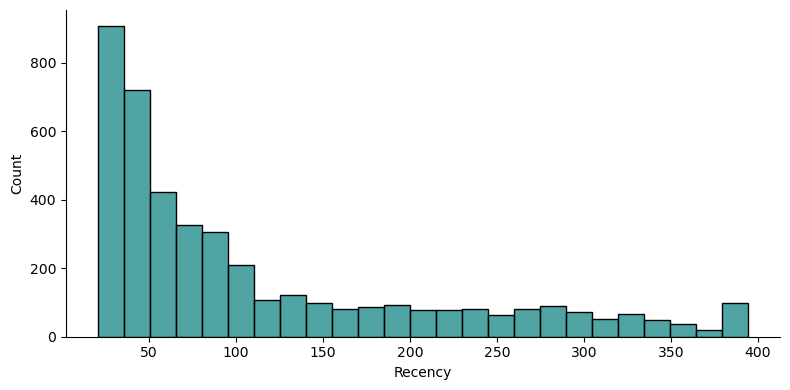

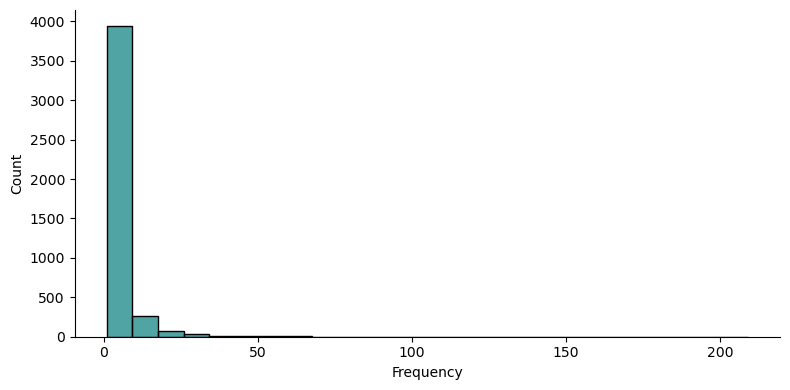

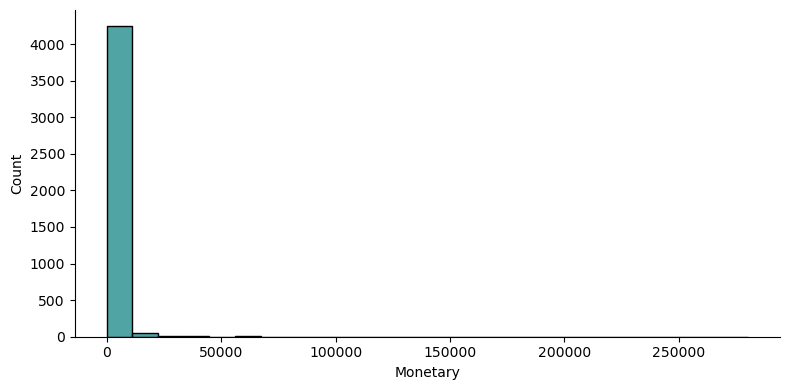

In [22]:
#the distribution plots of R, F and M
rfm_values = ['Recency', 'Frequency', 'Monetary']

for val in rfm_values:
    sns.displot(data=rfm_segment, x=val, height=4, aspect=2, color='#158685', bins=25)

Recency distribution is right-skewed, showing that the majority of customers made a purchase in the recent past. It has a long tail containing single customers who made their order long time ago. Similar pattern also appears on Frequency and Monetary distribution plots. The plots show that most customers has low frequency (small number of orders, around 10 per customer) and spend little amount of money in each transaction > Although the information is quite general (since we're using distribution plot and there might be other factors affecting the results), we've gained some insights of how customers are experiencing our services > find out the reasons why the RFM indicators are this low.

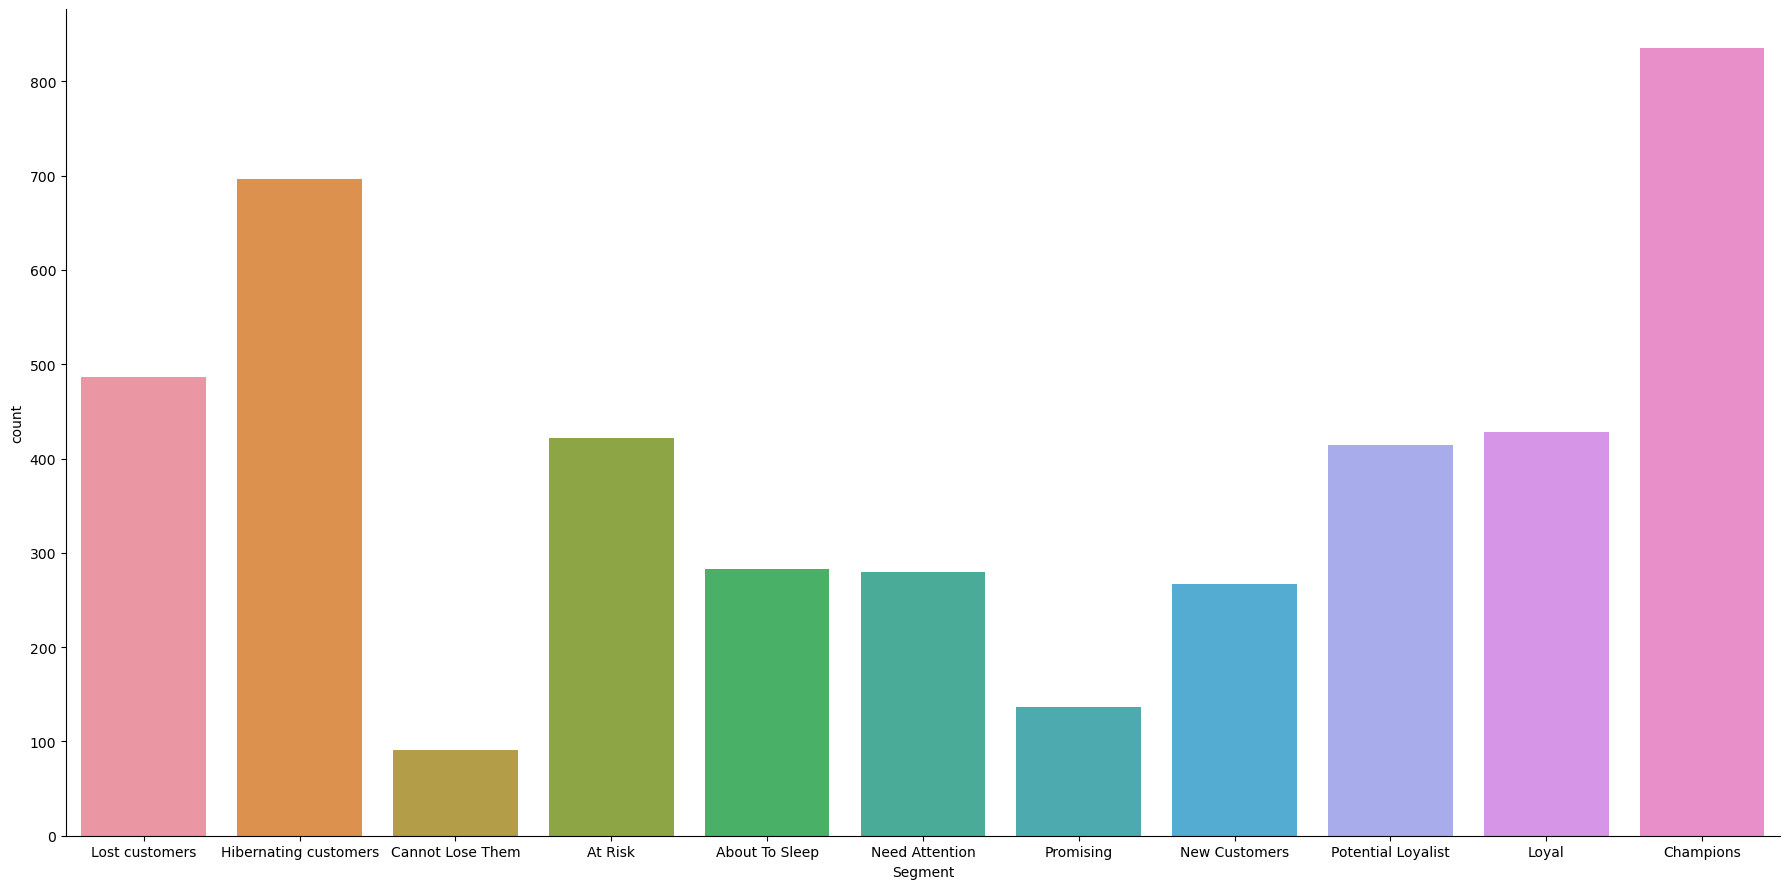

In [19]:
#Countplot
category_order = ['Lost customers',
                  'Hibernating customers',
                   'Cannot Lose Them',
                   'At Risk',
                   'About To Sleep',
                   'Need Attention',
                 'Promising',
                 'New Customers',
                 'Potential Loyalist',
                 'Loyal',
                 'Champions']
sns.catplot(data=rfm_segment, x='Segment', kind='count', height=9, aspect=2, order=category_order)

Analysis of clusters based on set of rules applied to RFM scores is much more diverse. Take a closer look at the count plot above, it's good to see that 'loyal customers' and 'potential loyalists' constitute around 1/6 of all customers. What is more, there is a large group of 'champions' who are the most profitable customers. At the same time it should worry that group of 'hibernating' is so big - about 700 customers of all customers. There is an opportunity that part of this group could be reactivated with a reach out campaign. Moreover, the company should focus on the group 'at risk' and 'lost customers' to increase customer retention (for lost customers, the company can choose to ignore them if needed). 

In [20]:
#Insert data for treemap
group = rfm_segment.groupby('Segment').agg({'CustomerID': 'count', 'Monetary': 'sum','Recency': 'mean'}).reset_index()
group.columns = ['Segment', 'Cust_cnt', 'total_sales', 'AVG_recency']
group.sort_values(by='Cust_cnt', ascending=False, inplace=True)
group

group['count_share'] = group['Cust_cnt'] / group['Cust_cnt'].sum()
group['monetary_share'] = group['total_sales'] / group['total_sales'].sum()
group

,Segment,Cust_cnt,total_sales,AVG_recency,count_share,monetary_share
3,Champions,835,5604376.680,31.816766,0.192485,0.628899
4,Hibernating customers,696,285673.342,169.916667,0.160443,0.032057
5,Lost customers,486,97405.610,296.557613,0.112033,0.010930
6,Loyal,428,1021224.390,57.070093,0.098663,0.114597
1,At Risk,422,751808.221,164.419431,0.097280,0.084365
9,Potential Loyalist,414,225740.110,47.053140,0.095436,0.025332
0,About To Sleep,283,77885.540,107.325088,0.065237,0.008740
7,Need Attention,280,462835.741,54.350000,0.064546,0.051937
8,New Customers,267,59755.620,48.891386,0.061549,0.006706
10,Promising,136,121031.350,45.904412,0.031351,0.013582


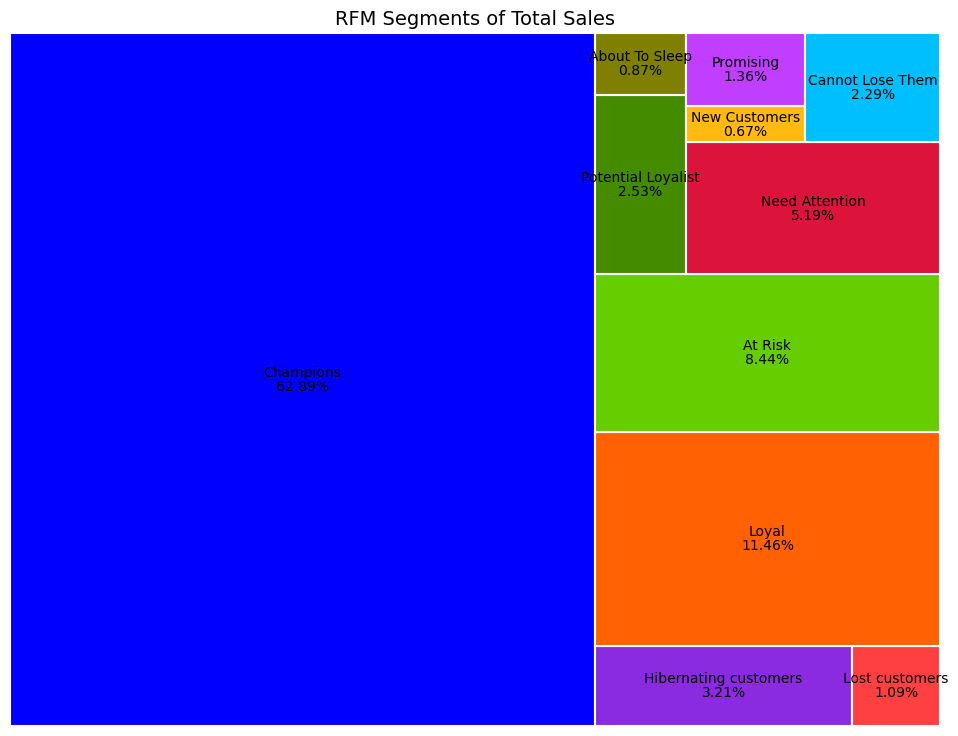

In [23]:
#Treemap
!pip install squarify
import squarify as sq
colors = ['#0000FF','#8A2BE2','#FF4040','#FF6103','#66CD00','#458B00','#808000','#DC143C','#FFB90F','#BF3EFF','#00BFFF']

fig, ax = plt.subplots(1, figsize = (12,9))

sq.plot(sizes = group['monetary_share'], 
              label = group['Segment'],
              value = [f'{x*100:.2f}%' for x in group['monetary_share']],
              alpha = 1,
              color = colors,
              bar_kwargs = dict(linewidth=1.5, edgecolor="white")
             )
plt.title('RFM Segments of Total Sales', fontsize=14)
plt.axis('off')
plt.show()

Based on the previous analysis of count plot, there are six group of customers that the company need to prioritise:
- Champions
- Loyal
- Potential loyalist
- At risk
- Hibernating customers
- Lost customers

With the treemap above, here are some recommendation for each cluster:
- The champions and loyal clusters bring the majority of sales to the company (74.35% in sum). This means that they are quite satisfied with the services (to some degrees). For those groups, the company can reward them and give them early access of new products. It's also a good strategy to engage the customers by asking for reviews so that they can be brand promoters.
- Despite the large number of customers, potential loyalist only spent a little amount of money (contribute 2.53% sales to company). For this group, it is necessary to Offer membership / loyalty program and Upsell higher value products. 
- At risk group has the same number of customer as loyal group. This type of group is known as spending big money and purchasing often long time ago (recency problems). Therefore, it is important to send them personalized emails to reconnect, offer renewals and offer special deals with the hope of bringing them back.
- The last two types is hibernating and lost customers. For hibernating, the company can reactivate them by offering other relevant products and special discounts and recreating brand value. Try all the best to prevent this group from converting into lost customers group. With lost customers, it is worth trying to revive interest with reach out campaign or reach out for feedbacks (this is important to improve services). Otherwise, the company can ignore them if needed.